In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
tf.__version__

'2.0.0'

In [3]:
def use_svg_display():
    """Use the svg format to display plot in jupyter."""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Change the default figure size"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize
    
def show_trace_2d(f, results):
    """Show the trace of 2D variables during optimization."""
    set_figsize((3.5, 2.5))
    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

## 梯度下降的问题

让我们考虑一个输入和输出分别为二维向量$\boldsymbol{x} = [x_1, x_2]^\top$和标量的目标函数$f(\boldsymbol{x})=0.1x_1^2+2x_2^2$,下面实现基于这个目标函数的梯度下降，并演示使用学习率为 0.4 时自变量的迭代轨迹。

In [5]:
def train_2d(trainer):
    """Optimize a 2-dim objective function with a customized trainer."""
    # s1 and s2 are internal state variables and will 
    # be used later in the chapter
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(20):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    print('epoch %d, x1 %f, x2 %f' % (i + 1, x1, x2))
    return results

epoch 20, x1 -0.943467, x2 -0.000073


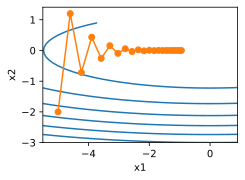

In [10]:
eat = 0.4

def fx(x1,x2):
    return 0.1 * x1**2 + 2 *x2**2

def gx(x1,x2,s1,s2):
    return (x1 -eat * 0.2*x1,x2 - eat * 4*x2,0,0)

show_trace_2d(fx,train_2d(gx))

可以看到，同一位置上，目标函数在竖直方向（ x2 轴方向）比在水平方向（ x1 轴方向）的斜率的绝对值更大。因此，给定学习率，梯度下降迭代自变量时会使自变量在竖直方向比在水平方向移动幅度更大。那么，我们需要一个较小的学习率从而避免自变量在竖直方向上越过目标函数最优解。然而，这会造成自变量在水平方向上朝最优解移动变慢。

epoch 20, x1 -0.387814, x2 -1673.365109


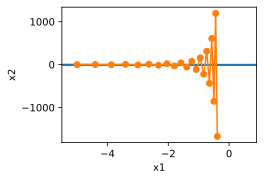

In [12]:
eat = 0.6
show_trace_2d(fx,train_2d(gx))

此时自变量在竖直方向不断越过最优解并逐渐发散。

## 动量法
设时间为t时刻的自变量为$x_t$学习率为$eta_t$,小批量梯度下降的梯度为$g_t$,动量法创建的速度量$v_t$,在t为0时$v_0 = 0$,则t时刻：
$$\begin{split}\begin{aligned}
\boldsymbol{v}_t &\leftarrow \gamma \boldsymbol{v}_{t-1} + \eta_t \boldsymbol{g}_t, \\
\boldsymbol{x}_t &\leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{v}_t,
\end{aligned}\end{split}$$

In [15]:
def momentum_2d(x1,x2,v1,v2):
    v1 = gamma * v1 + eta * 0.2 *x1
    v2 = gamma * v2 + eta * 4 * x2
    return (x1 - v1,x2 - v2,v1,v2)

epoch 20, x1 -0.062843, x2 0.001202


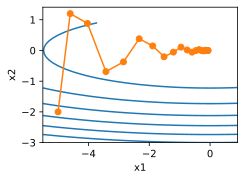

In [16]:
eta,gamma = 0.4,0.5
show_trace_2d(fx,train_2d(momentum_2d))

epoch 20, x1 0.007188, x2 0.002553


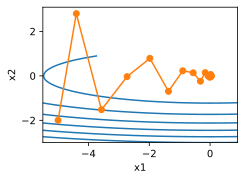

In [17]:
eta,gamma = 0.6,0.5
show_trace_2d(fx,train_2d(momentum_2d))

当使用较大的学习率时竖直方向不在发散

## 理解动量法

动量法本质是指数移动加权平均,我们常常将$y_t$看作是对最近$1/(1-\gamma)$个时间步的$x_t$值的加权平均。
$$\boldsymbol{v}_t \leftarrow \gamma \boldsymbol{v}_{t-1} + (1 - \gamma) \left(\frac{\eta_t}{1 - \gamma} \boldsymbol{g}_t\right).$$

当 γ=0.95 时， $v_t$可以被看作对最近20个时间步的$g_t$值的加权平均；当 γ=0.9 时，$v_t$可以看作是对最近10个时间步的$g_t$值的加权平均。而且，离当前时间步$t$越近的$g_t$值获得的权重越大（越接近1）。


## 动手实现动量法

In [97]:
def fx(x):
    w = tf.constant([4,-3],dtype=tf.float32)
    
    return tf.reduce_sum(x*w,axis=1)+5.0 + tf.random.normal(shape=(x.shape[0],))

x = tf.random.normal(shape=(1000,2))
y = fx(x)

In [19]:
def create_ds(x,y,batch_size):
    ds = tf.data.Dataset.from_tensor_slices((x,y))
    return ds.shuffle(1000).batch(batch_size).repeat()

In [20]:
ds = create_ds(x,y,20)

In [21]:
temp_x,temp_y = next(iter(ds))
temp_x,temp_y

(<tf.Tensor: id=37, shape=(20, 2), dtype=float32, numpy=
 array([[ 0.29185215, -1.1269016 ],
        [ 0.40639925,  0.31808284],
        [ 1.0156121 , -0.58480954],
        [-0.14320461, -0.07812241],
        [-0.20769864,  1.0051984 ],
        [ 0.11396961, -1.4903963 ],
        [-0.728156  , -0.56404114],
        [ 0.33496368, -0.6186714 ],
        [ 0.68776554,  0.682891  ],
        [-1.1630743 ,  0.47826743],
        [-1.3651953 , -0.35492125],
        [ 0.41324493, -0.86770546],
        [ 2.5779343 , -0.1214511 ],
        [ 2.715302  ,  0.37431836],
        [ 0.5987761 ,  0.8488023 ],
        [-0.37470263,  1.462645  ],
        [-0.7347533 , -0.26404878],
        [ 0.8999304 ,  1.1533198 ],
        [-1.4071106 , -0.5011136 ],
        [-0.14028835,  0.25213206]], dtype=float32)>,
 <tf.Tensor: id=38, shape=(20,), dtype=float32, numpy=
 array([11.744134  ,  7.0928874 , 12.144498  ,  5.8608756 ,  1.3860514 ,
         9.047338  ,  2.8122478 ,  7.8322234 ,  6.2351003 , -0.32875448,
    

In [22]:
def momentum_sgd(weight,bais,grads,v_w = 0,v_b=0,momentum = 0.9,eta = 0.2):
    v_w = momentum * v_w + eta*grads[0]
    v_b = momentum * v_b + eta*grads[1]
    return (weight - v_w,bais - v_b,v_w,v_b)

In [64]:
def model(x,w,b):
    return tf.reduce_sum(x * w,axis=1,name="sum") + b

def loss(y,y_hat):
    return tf.reduce_mean((y - y_hat) ** 2,name="loss") /2

In [47]:
def trainer(x,y,epcho=5,batch_size=10,momentum = 0.9,eta = 0.2):
    steps = 1000 // batch_size
    ds = create_ds(x,y,batch_size=batch_size)
    w = tf.ones(shape=(1,2))
    b = tf.zeros(shape=(1,))
    v_w,v_b=0,0
    losses = []
    for i in range(epcho):
        k = 0
        for x,label in ds:
            k += 1
            with tf.GradientTape() as tap:
                tap.watch([w,b])
                y_hat = model(x,w,b)
                l = loss(label,y_hat)
            grads = tap.gradient(l,[w,b])
            w,b,v_w,v_b = momentum_sgd(w,b,grads,0,0,momentum,eta)
            losses.append(l.numpy())
            if k == steps:
                break
        y_hat = model(x,w,b)
        l = loss(label,y_hat)
        print("epcho:", i+1 , "  loss:",l.numpy())
    print("w:",w.numpy()," b: ",b.numpy())
    return losses

def plt_losses(losses):
    plt.plot(range(len(losses)),losses)

epcho: 1   loss: 0.39026397
epcho: 2   loss: 0.49489412
epcho: 3   loss: 0.39819366
epcho: 4   loss: 0.5724337
epcho: 5   loss: 0.4750516
epcho: 6   loss: 0.5124684
epcho: 7   loss: 0.505174
epcho: 8   loss: 0.3033272
epcho: 9   loss: 0.4704823
epcho: 10   loss: 0.4880571
w: [[ 4.0943127 -3.0613105]]  b:  [5.033361]


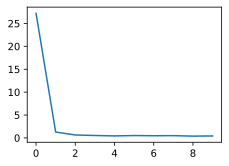

In [49]:
## 小批量随机梯度下降
losses = trainer(x,y,10,100,momentum=0.5,eta = 0.8)
plt_losses(losses[:10])

epcho: 1   loss: 0.39382863
epcho: 2   loss: 0.40054414
epcho: 3   loss: 0.43861023
epcho: 4   loss: 0.41089717
epcho: 5   loss: 0.49380463
epcho: 6   loss: 0.46874577
epcho: 7   loss: 0.48510194
epcho: 8   loss: 0.47008666
epcho: 9   loss: 0.4278589
epcho: 10   loss: 0.45120808
w: [[ 4.125874  -2.9134123]]  b:  [5.0261707]


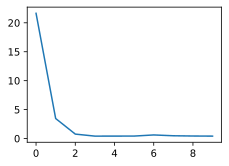

In [51]:
losses = trainer(x,y,10,100,momentum=0.9,eta = 0.8)
plt_losses(losses[:10])

epcho: 1   loss: 0.47465283
epcho: 2   loss: 0.40596554
epcho: 3   loss: 0.4411418
epcho: 4   loss: 0.41157365
epcho: 5   loss: 0.46804637
epcho: 6   loss: 0.47911063
epcho: 7   loss: 0.5686861
epcho: 8   loss: 0.4310171
epcho: 9   loss: 0.48399052
epcho: 10   loss: 0.44552562
w: [[ 4.0354867 -2.9209626]]  b:  [4.959605]


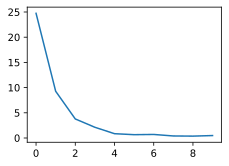

In [52]:
losses = trainer(x,y,10,100,momentum=0.9,eta = 0.4)
plt_losses(losses[:10])

## tensorflow中的动量法

In [111]:
class MyLayer(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super(MyLayer,self).__init__(**kwargs)
        self.w = self.add_weight(name="w",shape=(1,2),trainable = True,dtype=tf.float32,initializer=tf.keras.initializers.he_normal())
        self.b = self.add_weight(name="b",shape=(1,),trainable = True,dtype=tf.float32,initializer=tf.keras.initializers.he_normal())
    
    def call(self,x):
        return tf.reduce_sum(x * self.w,axis=1,name="sum") + self.b

In [112]:
layer = MyLayer()
layer(temp_x)

<tf.Tensor: id=169004, shape=(20,), dtype=float32, numpy=
array([-2.341508  , -1.8393675 , -3.1952806 , -1.183794  , -0.57714456,
       -2.2396312 , -0.516173  , -2.1692166 , -2.099042  ,  0.6382952 ,
        0.55705774, -2.405811  , -5.369644  , -5.3474827 , -1.885028  ,
       -0.10701728, -0.36542046, -2.2032619 ,  0.5526787 , -1.0334164 ],
      dtype=float32)>

In [129]:
medel = tf.keras.Sequential([
    layer
])

In [130]:
medel.compile(loss=tf.losses.mean_squared_error,metrics=["mae"],optimizer=tf.keras.optimizers.SGD(momentum=0.9,learning_rate=0.001))

In [131]:
history = medel.fit(ds,epochs=10,steps_per_epoch=100)

Train for 100 steps
Epoch 1/10
100/100 [==============================] - 0s 3ms/step - loss: 0.9567 - mae: 0.7896
Epoch 2/10
100/100 [==============================] - 0s 822us/step - loss: 0.9553 - mae: 0.7888
Epoch 3/10
100/100 [==============================] - 0s 832us/step - loss: 0.9554 - mae: 0.7890
Epoch 4/10
100/100 [==============================] - 0s 802us/step - loss: 0.9549 - mae: 0.7886
Epoch 5/10
100/100 [==============================] - 0s 822us/step - loss: 0.9552 - mae: 0.7888
Epoch 6/10
100/100 [==============================] - 0s 852us/step - loss: 0.9552 - mae: 0.7889
Epoch 7/10
100/100 [==============================] - 0s 832us/step - loss: 0.9559 - mae: 0.7891
Epoch 8/10
100/100 [==============================] - 0s 842us/step - loss: 0.9554 - mae: 0.7892
Epoch 9/10
100/100 [==============================] - 0s 892us/step - loss: 0.9551 - mae: 0.7889
Epoch 10/10
100/100 [==============================] - 0s 832us/step - loss: 0.9551 - mae: 0.7888


In [132]:
medel.variables

[<tf.Variable 'w:0' shape=(1, 2) dtype=float32, numpy=array([[ 4.008124 , -2.9912822]], dtype=float32)>,
 <tf.Variable 'b:0' shape=(1,) dtype=float32, numpy=array([4.9640784], dtype=float32)>]